In [1]:
from pathlib import Path
from detstats import *
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

In [21]:
cwd = Path('/home/saratoga/cs670-manga')
input_folder = cwd / 'inputs'
gt = GTMask(cwd / 'text_detection/post-processed.zip')
methods = ('db', 'er', 'swt', 'stub', 'east')
det_results = {method: DetArcMask(cwd / f'det_v2{method}.tar.gz') for method in methods}
methods3 = ('stub1', 'stub2', 'stub3', 'stub4', 'stub5')
det_results3 = {method: DetArcMask(cwd / f'det_v3{method}.tar.gz') for method in methods3}

(568,)


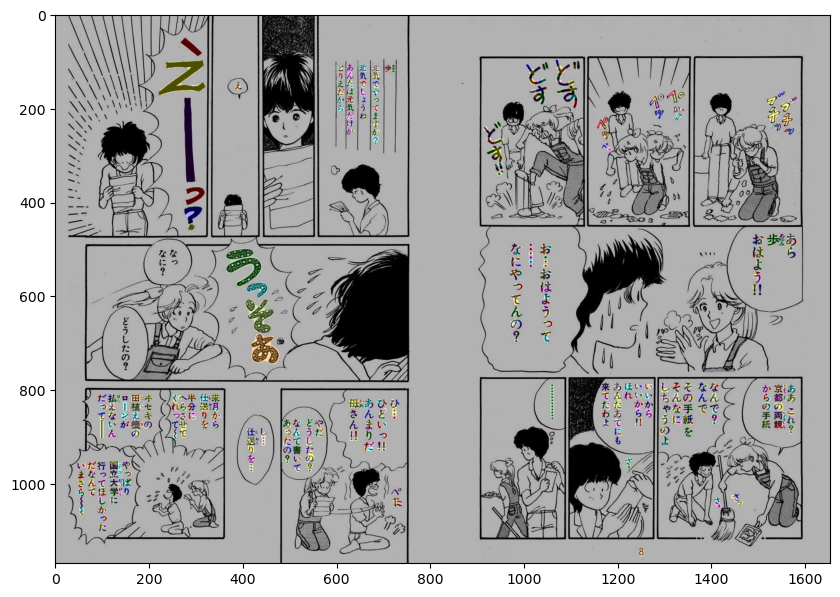

In [3]:
sample = Path('AisazuNihaIrarenai/004.jpg')
img = cv2.imread(str(Path('../inputs') / sample))
mask = gt.read_mask(sample)[:img.shape[0], :img.shape[1]]
plt.figure(figsize=(10, 10))
res = breakdown_color(mask, img)
print(np.unique(res[0]).shape)
plt.imshow(res[1])

In [4]:
cmp_sample = Path('AisazuNihaIrarenai/000.jpg')
cmp_sample_img = cv2.imread(str(input_folder / cmp_sample))
gt_mask = gt.read_mask(cmp_sample)[:cmp_sample_img.shape[0], :cmp_sample_img.shape[1]]
det_mask = det_results['er'].read_mask(cmp_sample)

cc = connected_stats(gt_mask, det_mask)
print(cc)

pa = pixelarea_stats(gt_mask, det_mask)
print(pa)

((165, 101, 24), (0.873015873015873, 0.6203007518796992), (0.9388105211978336, 0.05153273963477908, 0.09770244332173282), (0.8195964867600134, 0.03196579714187424, 0.0615317411990546))
((85078, 100718, 3677), (0.9585713480930652, 0.4579108269284592, 0.6197609915826203))


In [26]:
# from concurrent.futures import ProcessPoolExecutor
from skimage.transform import rescale


file_list = {f: gt.read_mask(f) for f in tqdm(gt.namelist())}
# print(len(file_list))
def compute_stats(gt_mask, mask):
    gt_mask = gt_mask[:mask.shape[0], :mask.shape[1]]
    _, quant, qual, glob = connected_stats(gt_mask, mask)
    _, pixel = pixelarea_stats(gt_mask, mask)
    return np.array([*quant, *qual, *glob, *pixel])


method = 'stub5'
output = det_results3[method]
total = np.zeros((11,))
print(f'Checking {method}')
n = 0
for f, gt_mask in tqdm(file_list.items(), miniters=1):
    true_f = Path(f).with_suffix('.jpg')
    mask = output.read_mask(true_f)
    gt_mask = gt_mask[:mask.shape[0], :mask.shape[1]]
    mask = rescale(mask, 0.4, anti_aliasing=False)
    gt_mask = rescale(gt_mask, 0.4, anti_aliasing=False)
    z = connected_stats(gt_mask, mask)
    if z is not None:
        _, quant, qual, glob = z
        n += 1
    _, pixel = pixelarea_stats(gt_mask, mask)
    # print('Processing done', f)
    total += np.array([*quant, *qual, *glob, *pixel])
# mask_generator = (output.read_mask(f) for f in file_list)
# with tqdm(total=len(file_list), miniters=1) as progress:
#     with ProcessPoolExecutor(max_workers=8) as executor:
#         for stat in executor.map(compute_stats, file_list.values(), mask_generator):
#             # print(stat)
#             total += stat
#             progress.update(1)

print(f'{method} result: {total}, {total / n}')
# stub [0.94762811 0.93496007 0.89054937 0.7720333  0.82166302 0.84347014 0.7247359  0.77152656 0.90737411 0.89266573 0.89445102]
# ER [0.94862074 0.93031431 0.88989892 0.7544201  0.80804912 0.84371644 0.70518698 0.75715129 0.91298674 0.84324219 0.86479267]
# DB [0.94911983 0.93935695 0.89429367 0.71366811 0.77931309 0.8481237 0.67360758 0.73438934 0.91193556 0.81238705 0.84785584]
# SWT [0.94694833 0.93668967 0.88352469 0.73621839 0.79513774 0.83619658 0.69291292 0.74739637 0.90969514 0.83839643 0.8659108 ]
# EAST [0.94849067 0.93854714 0.8927699  0.67501686 0.75278882 0.84780728 0.63851521 0.71129047 0.91418509 0.63627959 0.72621318]

# stub1 [0.96133436 0.89345386 0.89199186 0.7559786  0.81015357 0.85638899 0.68011895 0.74614417 0.93117631 0.83899259 0.87545973]
# stub2 [0.94762811 0.93496007 0.89054937 0.7720333  0.82166302 0.84347014 0.7247359  0.77152656 0.90737411 0.89266573 0.89445102]
# stub3 [0.93330445 0.95182389 0.88716496 0.77991967 0.82614907 0.82838165 0.74417492 0.77763478 0.882694   0.91436627 0.89248464]
# stub4 [0.91412938 0.96103179 0.88205247 0.78486258 0.82773452 0.80773828 0.75543408 0.77538009 0.84982409 0.93010949 0.88095883]
# stub5 [0.87663546 0.96911734 0.87231558 0.78715222 0.82548891 0.7686604 0.76341179 0.75974081 0.78851664 0.94475297 0.84769838]

100%|██████████| 450/450 [00:11<00:00, 40.09it/s]


Checking stub5


100%|██████████| 450/450 [07:16<00:00,  1.03it/s]

stub5 result: [393.60932284 435.13368438 391.6696967  353.4313467  370.64452256
 345.12851753 342.77189358 341.12362463 354.04396973 424.19408185
 380.61657462], [0.87663546 0.96911734 0.87231558 0.78715222 0.82548891 0.7686604
 0.76341179 0.75974081 0.78851664 0.94475297 0.84769838]
